# Gestalt Principles and CNNs
- Submitted by Sankalp Mittal (220963)

# Part a
In this part we are required to repriduce the study design using inception v4 networks instead of inception v3 networks

## InceptionV4 Implementation
I am using the following [github](https://github.com/kentsommer/keras-inceptionV4/tree/master) repository for the code for InceptionV4 model implementation as it was not available in the keras library

In [10]:
# from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
# from tensorflow.keras.models import Model
import inception_v4

2025-04-03 22:33:30.715351: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-03 22:33:30.716099: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-03 22:33:30.720426: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-03 22:33:30.734144: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743699810.755948   22324 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743699810.76

In [11]:
def build_inceptionV4(num_classes=1001, dropout_prob=0.2, weights='imagenet', include_top=True):
    try:
        return inception_v4.create_model(num_classes, dropout_prob, weights, include_top)
    except ValueError:
        try:
            return inception_v4.create_model(num_classes, dropout_prob, weights, include_top)
        except ValueError:
            return inception_v4.create_model(num_classes, dropout_prob, weights, include_top)

Just a check to see model is being built without any problems

In [12]:
model = build_inceptionV4(num_classes=1001, dropout_prob=0.2, weights='imagenet')

E0000 00:00:1743699815.421209   22324 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1743699815.421853   22324 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


# Generate Data
We generate the datasets using the `createImage` file using the following commands in the file directly
```
generate_global_symmetric_data()
```
We only generate global symmetry data as only that is asked in the question, even that comes out to be approximately __8GB__ in size just for _ds1_ and _ds2_ after which my system started killing the process, so I generated the datasets sequentially so that the run goes smoothly.

As even that was not working I just generated a dataset of size 10% of what was mentioned in the paper. 

# Part b
In this part we try to reproduce the results produced for InceptionV3 models with InceptionV4 for the case of detecting symmetry in images

We will use the same helper functions for training as in the case of InceptionV3 so I have imported them directly from the `train_incep3.py` file

In [13]:
import train_incep3
import os
import numpy as np

## Training Runs
This will run on ds1,ds2,ds3,ds4

In [23]:
def training_run(ds_path,resume_model = None, im_noise = False, num_classes = 2):
    ds = ds_path
    im_noise = False

    nb_epoch2 = 70

    if not os.path.exists('models'):
        os.mkdir('models')

    # load data
    tx, ty = train_incep3.read_dataset(ds+'/train.data')
    vx, vy = train_incep3.read_dataset(ds+'/valid.data')

    nTrainSample = len(ty)

    tx = train_incep3.preprocessing_img(tx)
    vx = train_incep3.preprocessing_img(vx)
    print("tx.shape: ", tx.shape)
    # print("ty.shape: ", ty.shape)
    print("vx.shape: ", vx.shape)
    # print("vy.shape: ", vy.shape)

    tx = np.asarray(tx)[:, np.newaxis, :, :]
    vx = np.asarray(vx)[:, np.newaxis, :, :]
    tx = np.repeat(tx, 3, axis=1)
    vx = np.repeat(vx, 3, axis=1)

        
    ty = train_incep3.to_categorical(ty, num_classes)
    vy = train_incep3.to_categorical(vy, num_classes)

    ## build model
    print("About to build model")
    model = build_inceptionV4(num_classes=num_classes)

    datagen = train_incep3.ImageDataGenerator(
        preprocessing_function=train_incep3.add_random_noise if im_noise else None,
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=5,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.02,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.02,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images
        

    if resume_model is not None:
        print('Resume model: ', resume_model)
        model.load_weights(resume_model)



    # model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])


    filepath2="models/"+ds+"_incep3-{epoch:02d}-{val_acc:.3f}.weights.h5"
    checkpoint2 = train_incep3.callbacks.ModelCheckpoint(filepath2, monitor='val_acc', verbose=0, save_best_only=True, mode='max', save_weights_only=True)

    early_stopper   = train_incep3.EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=40)

    callbacks_list2 = [early_stopper, checkpoint2]

    # we train our model 
    model.fit(datagen.flow(tx, ty, batch_size=40, shuffle=True),
                        steps_per_epoch=nTrainSample//40,
                        epochs=nb_epoch2,
                        validation_data=(vx, vy),
                        callbacks=callbacks_list2)

            
    # serialize last weights to HDF5
    model.save_weights(ds+"_incep3-%d.weights.h5"%(nb_epoch2))

    print("Saved last weights to disk")

In [ ]:
# Training run 1
training_run("data\\symmetry_global\\ds1", resume_model = None, im_noise = False)
# Training run 2
training_run("data\\symmetry_global\\ds2", resume_model = None, im_noise = False) # Train a new model according to the paper
# Training run 3
training_run("data\\symmetry_global\\ds3", resume_model = None, im_noise = False) # Train a new model according to the paper
# Training run 4
training_run("data\\symmetry_global\\ds4", resume_model = None, im_noise = False)

: 

Since the kernel is crashing repetedly even after trying out lots of modifications I have just written the code without testing it.

## Testing Run
This will also run on ds1,ds2,ds3,ds4

We will use the same helper functions for testing as in the case of InceptionV3 so I have imported them directly from the `test_incep3.py` file

In [15]:
import test_incep3
import matplotlib.pyplot as plt

In [21]:
def testing_run(ds_number=1,debug=True, modelfile=None, num_classes=2):
    debug = debug
    ds = f"data\\symmetry_global\\ds{ds_number}"
    testfile = 'test.data'
    modelfile = modelfile
    
    
    nb_epoch2 = 70
    
    model = build_inceptionV4(num_classes=num_classes)

    if modelfile is None:
        model_weights = ds+"_incep3-%d.hdf5"%(nb_epoch2)
    else:
        model_weights = modelfile
    
    print('load weight: ',model_weights)
    model.load_weights(model_weights)
    
    # load testing data
    tx, ty = test_incep3.read_dataset(os.path.join(ds,testfile))
    tx = test_incep3.preprocessing_img(tx)
    tx = np.asarray(tx)[:, np.newaxis, :, :]
    tx = np.repeat(tx, 3, axis=1)
    
    print('test on %d samples'%len(ty))
    
    preds = model.predict(tx, verbose=0)
    print("error:",test_incep3.get_error(ty, preds[:,1]>preds[:,0]))
    print("confusion:")
    print(test_incep3.get_confusion_matrix(ty, preds[:,1]>preds[:,0]))
    
    fpr, tpr, thresholds = test_incep3.metrics.roc_curve(ty, preds[:,1], pos_label=1)
    auc = test_incep3.metrics.auc(fpr, tpr)
    plt.ion()
    plt.plot(fpr, tpr)
    plt.title('auc: '+str(auc))
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.show()
    
    #----------
    ## debug: dump error cases
    if debug:
        err_dump_dir = 'err_'+ds+'_'+testfile[:-len('.data')]
        if os.path.exists(err_dump_dir):
            test_incep3.shutil.rmtree(err_dump_dir)
        os.mkdir(err_dump_dir)
        
        os.mkdir(os.path.join(err_dump_dir, '0'))
        os.mkdir(os.path.join(err_dump_dir, '1'))
        n_0 = sum(np.array(ty)==0)
        for i in range(n_0):
            y, py = ty[i], preds[i,1]
            if y != (py>0.5):
                test_incep3.misc.imsave(os.path.join(err_dump_dir, str(y), str(i)+'_'+str(py)+'.png'), tx[i, 0])
        for i in range(n_0, len(ty)):
            y, py = ty[i], preds[i,1]
            if y != (py>0.5):
                test_incep3.misc.imsave(os.path.join(err_dump_dir, str(y), str(i-n_0)+'_'+str(py)+'.png'), tx[i, 0])

In [ ]:
# Test Model 1
testing_run("data\\symmetry_global\\ds1", debug=True, modelfile=None)
# Test Model 2
testing_run("data\\symmetry_global\\ds2", debug=True, modelfile=None)
# Test Model 3
testing_run("data\\symmetry_global\\ds3", debug=True, modelfile=None)
# Test Model 4
# Test using model 1,2,3 according to the paper
testing_run("data\\symmetry_global\\ds4", debug=True, modelfile="models/data\\symmetry_global\\ds1_incep3-70.weights.h5")
testing_run("data\\symmetry_global\\ds4", debug=True, modelfile="models/data\\symmetry_global\\ds2_incep3-70.weights.h5")
testing_run("data\\symmetry_global\\ds4", debug=True, modelfile="models/data\\symmetry_global\\ds3_incep3-70.weights.h5")
testing_run("data\\symmetry_global\\ds4", debug=True, modelfile="models/data\\symmetry_global\\ds4_incep3-70.weights.h5")

# Part c

## Generate Data
First of all we need to generate data for this part as I was not getting the appropriate dataset online, I have written the code to generate this dataset myself by modifying the __MNIST dataset__ in the `createImage_withDots.py` file. This basically takes the data and adds dots spaced evenly throughout the image since the image is white and the background is black adding black dots will only cover the image.
Just run the file as
```
python createImage_withDots.py
```
The images will be stored in the `mnist_dots` directory

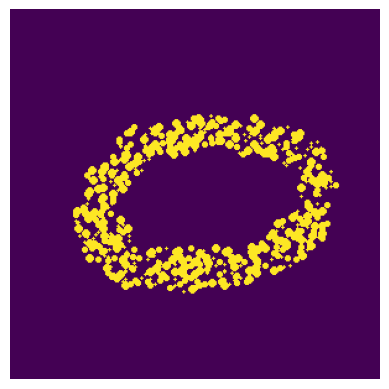

In [17]:
# Display a sample of the images created
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_path = "mnist_dots/test/0/0.png"

img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis("off")  # Hide axis
plt.show()

## Train and Test

Since the model is not training in my computer I have not trained it but the code that is used in the above case can be reused

In [24]:
training_run("mnist_dots", resume_model = None, im_noise = False,num_classes=10)

tx.shape:  (20, 299, 299)
vx.shape:  (20, 299, 299)
About to build model


/home/sankalp/CGS786_assn3/final_implementation/inception_v4.py:279: UserWarning: You are using the TensorFlow backend, yet you are using the Theano image data format convention (`image_data_format="channels_first"`). For best performance, set `image_data_format="channels_last"` in your Keras config at ~/.keras/keras.json.
  warnings.warn('You are using the TensorFlow backend, yet you '
/home/sankalp/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/70


: 

In [ ]:
testing_run("mnist_dots", debug=True, modelfile=None)